#**Machine Remaining Useful Life Estimation Using LSTNet**

Predicting the remaining useful life time of the machine using LSTNet model proposed by [[1]](https://github.com/laiguokun/LSTNet).

##Imports:

Imoprt the necessary files and packages.

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

from PreProcessing import *
from model import *
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error
import torch.nn as nn
import matplotlib.pyplot as plt

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)


## Load and Visualize the data

In [ ]:
(X_dev,y_dev),(X_test,y_test) = load_NCMAPSS_data()

In [ ]:
#Show some samples from the data table 
X_dev.head()

,unit,cycle,Fc,hs,T24,T30,T48,T50,P15,P2,...,W22,W25,W31,W32,W48,W50,SmFan,SmLPC,SmHPC,phi
0,1.0,1.0,1.0,1.0,632.830608,1525.667253,1953.949543,1319.505339,20.431550,14.614995,...,297.155803,297.152426,34.609880,20.765928,282.413502,298.756679,15.355652,10.502229,24.031103,44.382600
1,1.0,1.0,1.0,1.0,632.859504,1525.696748,1953.927850,1319.441504,20.433361,14.616348,...,297.168238,297.165520,34.611427,20.766856,282.426011,298.770010,15.362718,10.497703,24.034327,44.380758
2,1.0,1.0,1.0,1.0,632.889882,1525.725093,1953.948358,1319.424113,20.435964,14.618606,...,297.183596,297.181313,34.613293,20.767976,282.441066,298.785912,15.370152,10.492989,24.036347,44.380697
3,1.0,1.0,1.0,1.0,632.920333,1525.759185,1953.952618,1319.375074,20.437438,14.619858,...,297.190911,297.187731,34.614051,20.768430,282.447355,298.792520,15.379321,10.488816,24.038863,44.379708
4,1.0,1.0,1.0,1.0,632.956016,1525.785508,1953.952454,1319.329057,20.440027,14.622166,...,297.200890,297.198232,34.615291,20.769175,282.457126,298.802889,15.388950,10.482465,24.042040,44.378914


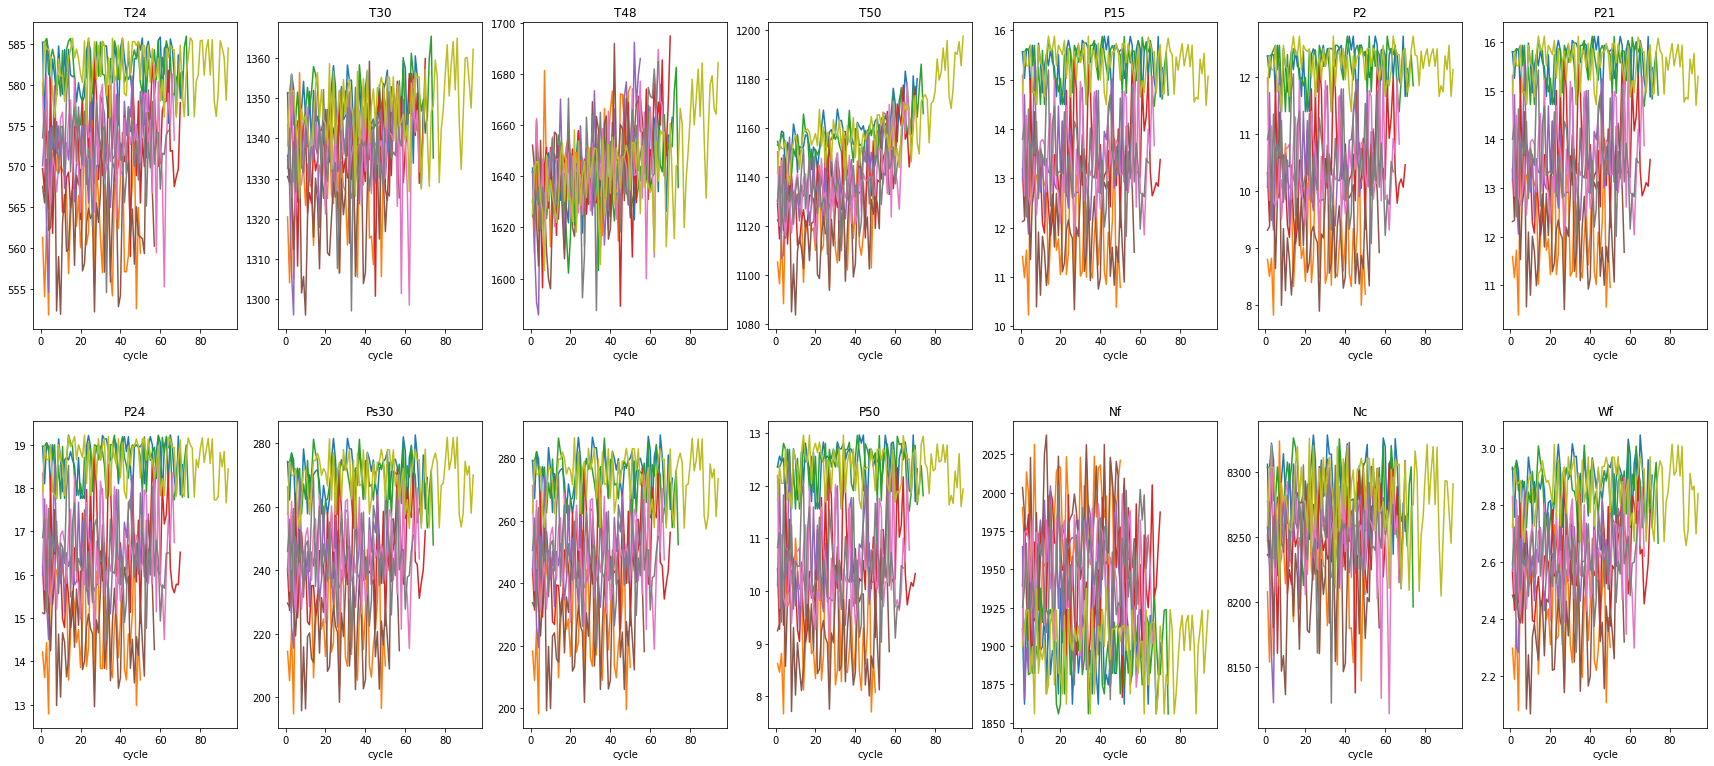

In [ ]:
# Plot the sensors readings 
plot_senors_reading(X_dev)

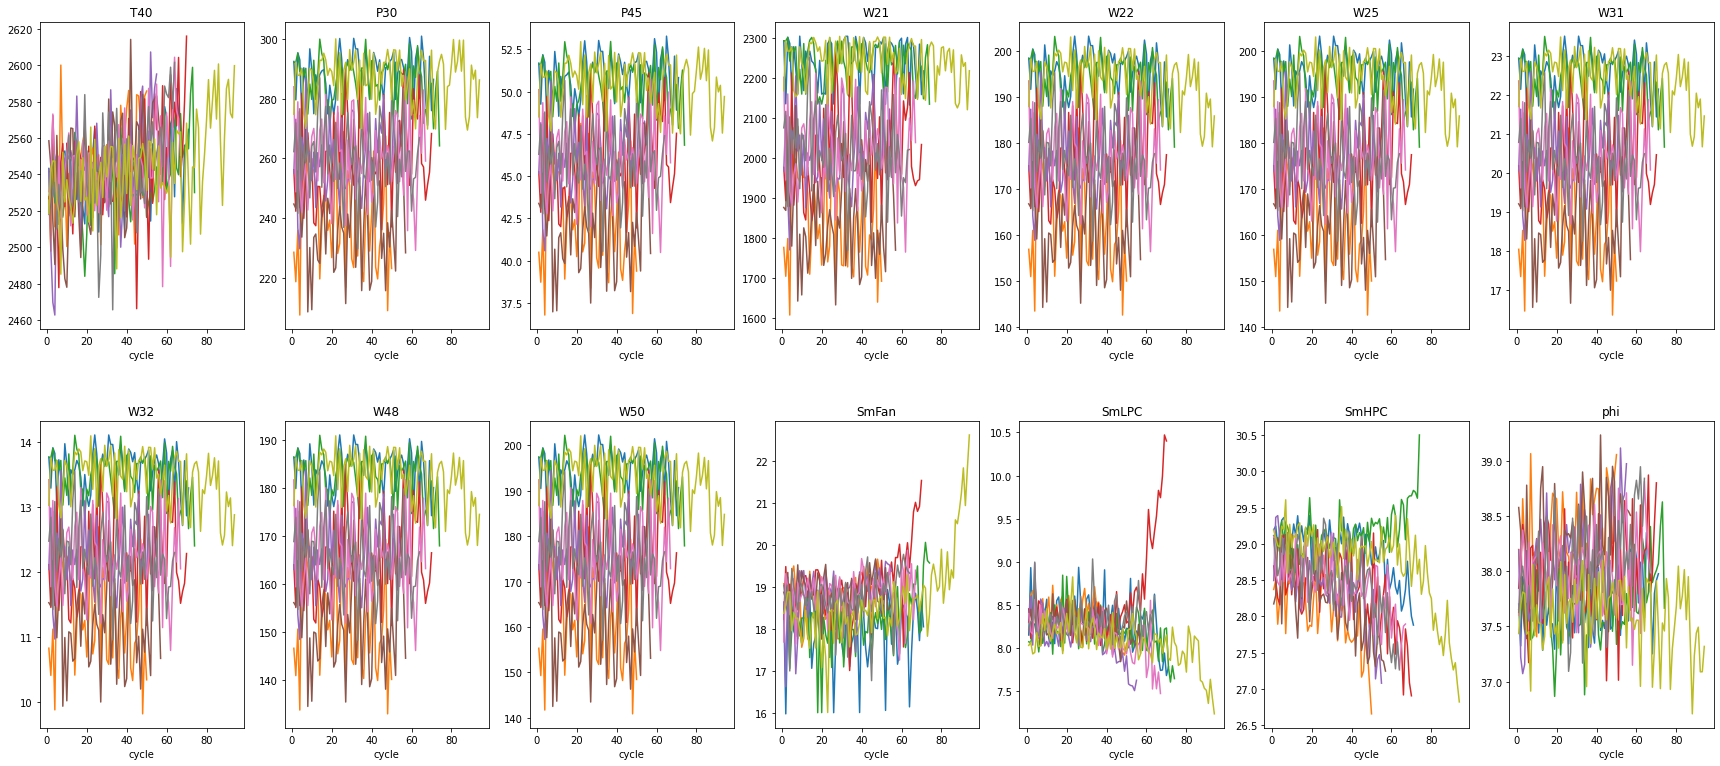

In [ ]:
#Plot the virtual sensors readings
plot_virtual_senors_reading(X_dev)

##Prepare the Data for training

In [ ]:
# Normalize the data

X_dev_normalized,X_test_normalized = data_normalization(X_dev,X_test)


In [ ]:

# Implement a custom Dataset  for NCMAPPS Dataset :

class NCMAPPS(Dataset):

    def __init__(self,x,y,history_len):
        # Initialize data
        '''
        parameters:
        x : dataframe that from which we took the sensors measurments only
        y : target rul
        history_len : the length of the sequennce to be considered for each sample
        '''
        self.history_len = history_len
        c_sensors = x.columns[4:-1] # Extract the sonsors reading
        # the coloumns with indecies [0-3] are auxiliary variables

        self.x = x[c_sensors]
        self.x= torch.tensor(self.x.to_numpy()).float() # Convert to numpy array for easier handling and then for a tensor
        self.y= torch.tensor(y)                                                     
        self.n_samples = x.shape[0]
        
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        # return the sequence from the index up to the index + history_len 
        # and the target will be the rul at time == index + history_len

        return self.x[index: index+self.history_len, :], self.y[index+self.history_len, :]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples-self.history_len



def train_validation_split(X_dev,y_dev):
  '''
  parameters:
  X_dev : Development data set(features matrix) which has to be splitted into train and validation sets
  y_dev : Development targets to be spliited into train and validation sets

  this function took the development set and split it into train and validation
  it return the data for two random units as a validation set and the remaining units for the train
  '''
  units = np.unique(X_dev.unit) # units within the dataset

  i,j = np.random.randint(1,np.max(units)+1,2) # generate two random numbers within the range(1,unit with the maximum number)

  index = (X_dev.unit==i) + (X_dev.unit == j) # index to selects a two random units as a validation set
  
  #Train set
  X_train = X_dev[~index]
  y_train = y_dev[~index]

  #Validation
  X_validation = X_dev[index]
  y_validation = y_dev[index]

  return (X_train,y_train),(X_validation,y_validation)

##Define and train the Model 

In [ ]:
# initiate a parameters object to define the parameters of the model
params = parameters(27,10,10,64,[24,4],[4,4],7,slice(3,4),0.25,1,device)

In [ ]:
# initiate an object from the model
LSTNet = Model(params)

In [ ]:
#Split the data into train and validation

(X_train,y_train),(X_val,y_val) = train_validation_split(X_dev_normalized,y_dev)

#define the train and validation sets
train_set = NCMAPPS(X_train,y_train,100)
val_set = NCMAPPS(X_val,y_val,100)


In [ ]:
# The function that performs the training
def training_loop(n_epochs, optimiser, model, loss_fn,batch_size, train_loader,val_loader ):
  '''
  Parameters:
  n_epochs :  number of epochs
  optimiser : optimiser used for training
  model : the model to be trained 
  loss_fn : loss function used to train the model
  batch_size : the batch size 
  train_loader : dataloader object to load the training data during the training
  val_loader : dataloader object to load the validation data during the training
  '''
    
  train_curve = [] # list to save the mean of the training loss for each epoch
  #the elements of this list will be the value of the training loss for each epoch

  val_curve = [] # list to save the mean of the validation loss for each epoch 
  

  for epoch in range(0, n_epochs):

    train_loss = [] #list to save the mean of the training loss for each iteration
    #the elements of this list will be the value of the training loss for iteration
  
    val_loss = [] # list to save the mean of the training loss for each iteration
    
    model.train(True)
    for i ,(features,targets) in enumerate(train_loader):
      features= features.to(device)
      targets= targets.to(device)
      output_train = model.forward(features) # forwards pass
      targets = torch.tensor(targets,dtype=torch.float32)
      loss_train = loss_fn(output_train, targets) # calculate the loss
      optimiser.zero_grad() # set gradients to zero
      loss_train.backward() # backwards pass
      optimiser.step() # update model parameters
      
      train_loss.append(loss_train.item()) #append the value of the training loss of the i-th iteration

    model.train(False) # to test the model on the validation set

    for i ,(features,targets) in enumerate(val_loader):
        features= features.to(device)
        targets= targets.to(device)
        output_val = model.forward(features) # forwards pass
        targets = torch.tensor(targets,dtype=torch.float32)
        loss_val = loss_fn(output_val, targets) # calculate loss
        val_loss.append(loss_val.item()) #append the value of the validation loss of the i-th iteration

        
        
    print(f"Epoch {epoch}, Training loss {np.mean(train_loss):.4f},"
                  f" Validation loss {np.mean(val_loss):.4f}")
    
    val_curve.append(np.mean(val_loss)) #append the value of the training loss of the epoch 
    train_curve.append(np.mean(train_loss)) # #append the value of the validation loss of the epoch
    

    
  return (train_curve,val_curve)

In [ ]:
#Define the parameters for training 
batch_size= 1024
n_epochs = 2
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters())

#DataLoaders
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=False)

val_loader = DataLoader(dataset=val_set,
                          batch_size=batch_size,
                          shuffle=False)

In [ ]:
(training_curve,validation_curve) = training_loop(n_epochs=n_epochs,optimiser=optim,model=LSTNet,
                                      loss_fn=loss_fn,batch_size=batch_size,train_loader=train_loader,val_loader=val_loader)

Epoch 0, Training loss 318.2150, Validation loss 771.4070
Epoch 1, Training loss 257.9419, Validation loss 663.7683


##Model Evaluation:

In [ ]:
def predict(model,data_set):
  '''
  function to predict the rul 
  parameter:
  model : the trained model to predcit the output
  data_set : data_set object to predict the ouput for it
  '''
  batch_size = 1024
  y_pred = np.zeros((len(data_set)+data_set.history_len,1)) # vector to save the predicted output

  data_loader = DataLoader(dataset = data_set,batch_size = batch_size,shuffle = False)
  for i,(x,y) in enumerate(data_loader):
    model.train(False)
    x = x.to(device)
    y_p = model.forward(x)
    y_pred[i*batch_size:(i*batch_size+y_p.shape[0])] = y_p.cpu().detach().numpy()
  
  return y_pred

In [ ]:
#------------First Evaluate on the Devlopment set (train and validation)-------------#
dev_set = NCMAPPS(X_dev_normalized,y_dev,100)
y_pred = predict(LSTNet,dev_set)

In [ ]:
mse_train = mean_squared_error(y_dev,y_pred)
rmse_train = mean_squared_error(y_dev,y_pred,squared=False)

print(f'The mean squared error for train set      :  {np.mean(mse_train):.4f}')
print(f'The root mean squared error for train set :  {np.mean(rmse_train):.4f}')

The mean squared error for train set      :  699.9162
The root mean squared error for train set :  26.4559


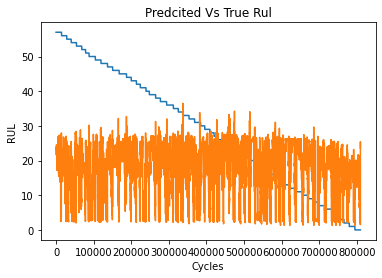

In [ ]:

#Plot the prediction for the specific unit

unit = 6 # For the dev set it range from 1 to 9 
index = X_dev_normalized.unit==unit


plt.plot(y_dev[index],label='True Rul')
plt.plot(y_pred[index],label='Predicted Rul')
plt.legend()
plt.xlabel('Cycles')
plt.ylabel('RUL')
plt.title('Predcited Vs True Rul')
plt.show()

In [ ]:
#---------------Evalute on Test set -----------------------#
test_set = NCMAPPS(X_test_normalized,y_test,100)
y_pred = predict(LSTNet,test_set)

In [ ]:
mse_test = mean_squared_error(y_test,y_pred)
rmse_test = mean_squared_error(y_test,y_pred,squared=False)

print(f'The mean squared error for test set      :  {np.mean(mse_test):.4f}')
print(f'The root mean squared error for test set :  {np.mean(rmse_test):.4f}')

The mean squared error for test set      :  552.4381
The root mean squared error for test set :  23.5040


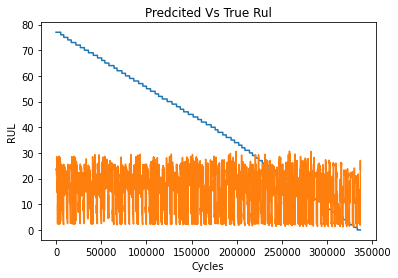

In [ ]:
#Plot the prediction for the specific unit

unit = 10 # For test set it range from 10 to 15 
index = X_test_normalized.unit==unit

plt.plot(y_test[index],label='True Rul')
plt.plot(y_pred[index],label='Predicted Rul')
plt.xlabel('Cycles')
plt.ylabel('RUL')
plt.title('Predcited Vs True Rul')
plt.show()